## Datos

In [1]:
#librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import median_absolute_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
df=pd.read_excel('CompleteVentas.xlsx', index_col=0, parse_dates=True)
df.head()

,T,Day,LOC,cluster,SKU,ProdCluster,UNI,Tr/T
FECHA,,,,,,,,
2019-04-01,0,L,LOC_001,0,Art02,5,1,Tr
2019-04-01,0,L,LOC_001,0,Art04,2,1,Tr
2019-04-01,0,L,LOC_002,0,Art04,2,1,Tr
2019-04-01,0,L,LOC_002,0,Art06,5,1,Tr
2019-04-01,0,L,LOC_002,0,Art08,3,1,Tr


In [3]:
df['UNI']=df['UNI'].astype('float64')
df['T']=df['T'].astype('float64')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96676 entries, 2019-04-01 to 2019-06-23
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   T            96676 non-null  float64
 1   Day          96676 non-null  object 
 2   LOC          96676 non-null  object 
 3   cluster      96676 non-null  int64  
 4   SKU          96676 non-null  object 
 5   ProdCluster  96676 non-null  int64  
 6   UNI          96676 non-null  float64
 7   Tr/T         96676 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 6.6+ MB


In [5]:
Traindf=df[df['Tr/T']=='Tr']
Testdf=df[df['Tr/T']=='T']

In [6]:
# datos de entrenamiento para el modelo
y_train=Traindf.UNI.values
X_traindf=Traindf.drop(columns=['UNI','cluster','ProdCluster','Tr/T'])
X_traindf.head()

,T,Day,LOC,SKU
FECHA,,,,
2019-04-01,0.0,L,LOC_001,Art02
2019-04-01,0.0,L,LOC_001,Art04
2019-04-01,0.0,L,LOC_002,Art04
2019-04-01,0.0,L,LOC_002,Art06
2019-04-01,0.0,L,LOC_002,Art08


In [7]:
X_traindf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80290 entries, 2019-04-01 to 2019-06-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       80290 non-null  float64
 1   Day     80290 non-null  object 
 2   LOC     80290 non-null  object 
 3   SKU     80290 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.1+ MB


In [8]:
encoder = ColumnTransformer(
    [('number1', OneHotEncoder(handle_unknown='ignore'), [1,2,3])],
    remainder="passthrough"
)
encoder.fit(X_traindf.values)
X_train=encoder.transform(X_traindf.values).toarray()
X_train.shape

(80290, 433)

In [9]:
# datos de prueba para el modelo
y_test=Testdf.UNI.values
X_testdf=Testdf.drop(columns=['UNI','cluster','ProdCluster','Tr/T'])
X_testdf.head()

,T,Day,LOC,SKU
FECHA,,,,
2019-06-10,70.0,L,LOC_001,Art01
2019-06-10,70.0,L,LOC_001,Art02
2019-06-10,70.0,L,LOC_001,Art04
2019-06-10,70.0,L,LOC_001,Art06
2019-06-10,70.0,L,LOC_001,Art09


In [10]:
X_testdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16386 entries, 2019-06-10 to 2019-06-23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       16386 non-null  float64
 1   Day     16386 non-null  object 
 2   LOC     16386 non-null  object 
 3   SKU     16386 non-null  object 
dtypes: float64(1), object(3)
memory usage: 640.1+ KB


In [11]:
X_test=encoder.transform(X_testdf.values).toarray() #17%
X_test.shape

(16386, 433)

In [12]:
print(X_train.shape)
print(X_test.shape)

(80290, 433)
(16386, 433)


## Entrenamiento

In [13]:
startTime = datetime.now()

gbm_param_grid={'learning_rate':[0.3,0.6], #1e-5,1e-4,1e-3,1e-2,1e-1,0.3,0.5,0.9
               'n_estimators':[15,50],
               'subsample':[1],
                'colsample_bytree':[0.8,1],
               'gamma':[0,110],
               'lambda':[0,7]
               }


gbm=xgb.XGBRegressor(seed=123)

grid_mse=GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)

grid_mse.fit(X_train,y_train)





print(datetime.now() - startTime)

0:26:31.987296


In [14]:
# Print the tuned parameters and score
print("Tuned xgb Parameters: {}".format(grid_mse.best_params_)) 
print("Best score is {}".format(grid_mse.best_score_))

Tuned xgb Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'lambda': 7, 'learning_rate': 0.6, 'n_estimators': 50, 'subsample': 1}
Best score is -1.5311226092511592


In [15]:
grid_mse=xgb.XGBRegressor(seed=123, learning_rate=0.6,n_estimators=500,subsample=1,gamma=0,reg_lambda=7,colsample_bytree=0.8)
                    
grid_mse.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=10)

[0]	validation_0-rmse:1.49663
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.37634
[2]	validation_0-rmse:1.24053
[3]	validation_0-rmse:1.21378
[4]	validation_0-rmse:1.20266
[5]	validation_0-rmse:1.19472
[6]	validation_0-rmse:1.18973
[7]	validation_0-rmse:1.18670
[8]	validation_0-rmse:1.18466
[9]	validation_0-rmse:1.18287
[10]	validation_0-rmse:1.18054
[11]	validation_0-rmse:1.17770
[12]	validation_0-rmse:1.17415
[13]	validation_0-rmse:1.17169
[14]	validation_0-rmse:1.16798
[15]	validation_0-rmse:1.16631
[16]	validation_0-rmse:1.16567
[17]	validation_0-rmse:1.16477
[18]	validation_0-rmse:1.16406
[19]	validation_0-rmse:1.16220
[20]	validation_0-rmse:1.16166
[21]	validation_0-rmse:1.15963
[22]	validation_0-rmse:1.15891
[23]	validation_0-rmse:1.15793
[24]	validation_0-rmse:1.15786
[25]	validation_0-rmse:1.15643
[26]	validation_0-rmse:1.15636
[27]	validation_0-rmse:1.15680
[28]	validation_0-rmse:1.15647
[29]	validation_0-rmse:1.15611
[30]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.6, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=7, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Predicción

In [16]:
# predecir datos de prueba
y_pred_train_xgb = np.round(grid_mse.predict(X_train),0)
y_pred_test_xgb = np.round(grid_mse.predict(X_test),0)

## Evaluación

In [17]:
#train
print('train')
mse=mean_squared_error(y_train,y_pred_train_xgb)
r2=r2_score(y_train,y_pred_train_xgb)
mae=median_absolute_error(y_train,y_pred_train_xgb)
print((mse)**(0.5),r2,mae)

train
1.1355233932025137 0.5004165172447861 1.0


In [18]:
#test
print('test')
mse=mean_squared_error(y_test,y_pred_test_xgb)
r2=r2_score(y_test,y_pred_test_xgb)
mae=median_absolute_error(y_test,y_pred_test_xgb)
print((mse)**(0.5),r2,mae)

test
1.1967448424751903 0.31697342512170334 1.0


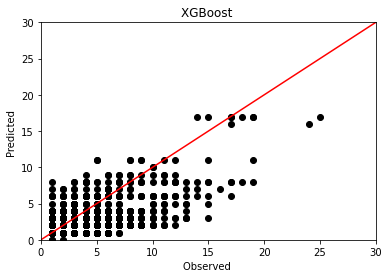

In [19]:
# Figura 8
xl=[0,30]
yl=[0,30]
#plt.figure(figsize = (15,10))
plt.plot(xl,yl, color='red')
plt.scatter(y_test,y_pred_test_xgb,color='black')
plt.xlim([0,30])
plt.ylim([0,30])
plt.xlabel('Observed '), plt.ylabel('Predicted '), plt.title('XGBoost ')
plt.show()

## Prueba

In [20]:
df=pd.read_excel('Test5.xlsx', index_col=0, parse_dates=True)
df['UNI']=df['UNI'].astype('float64')
df['T']=df['T'].astype('float64')
df.head()

,T,Day,LOC,cluster,SKU,ProdCluster,UNI,Tr/T,xgb,ts,baseline
FECHA,,,,,,,,,,,
2019-06-10,70.0,L,LOC_003,1,Art01,3,0.0,T,2,3,3.15
2019-06-11,71.0,M,LOC_003,1,Art01,3,3.0,T,2,3,3.15
2019-06-12,72.0,Mi,LOC_003,1,Art01,3,3.0,T,2,3,3.15
2019-06-13,73.0,J,LOC_003,1,Art01,3,0.0,T,2,3,3.15
2019-06-14,74.0,V,LOC_003,1,Art01,3,0.0,T,2,3,3.15


In [21]:
y_test=df.UNI.values
X_testdf=df.drop(columns=['UNI','cluster','ProdCluster','Tr/T','xgb','ts','baseline'])
X_testdf.head()

,T,Day,LOC,SKU
FECHA,,,,
2019-06-10,70.0,L,LOC_003,Art01
2019-06-11,71.0,M,LOC_003,Art01
2019-06-12,72.0,Mi,LOC_003,Art01
2019-06-13,73.0,J,LOC_003,Art01
2019-06-14,74.0,V,LOC_003,Art01


In [22]:
X_testdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2019-06-10 to 2019-06-18
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       16 non-null     float64
 1   Day     16 non-null     object 
 2   LOC     16 non-null     object 
 3   SKU     16 non-null     object 
dtypes: float64(1), object(3)
memory usage: 640.0+ bytes


In [23]:
X_test=encoder.transform(X_testdf.values).toarray() #17%
X_test.shape

(16, 433)

In [24]:
y_pred_test_xgb = np.round(grid_mse.predict(X_test),0)

In [25]:
#test
print('test')
mse=mean_squared_error(y_test,y_pred_test_xgb)
r2=r2_score(y_test,y_pred_test_xgb)
mae=median_absolute_error(y_test,y_pred_test_xgb)
print((mse)**(0.5),r2,mae)

test
3.072051431861127 -0.0961887477313974 2.0


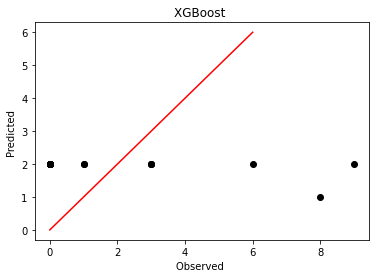

In [26]:
# Figura 8
xl=[0,6]
yl=[0,6]
#plt.figure(figsize = (15,10))
plt.plot(xl,yl, color='red')
plt.scatter(y_test,y_pred_test_xgb,color='black')
#plt.xlim([0,6])
#plt.ylim([0,6])
plt.xlabel('Observed '), plt.ylabel('Predicted '), plt.title('XGBoost ')
plt.show()

In [27]:
y_pred_test_xgb

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.],
      dtype=float32)

In [28]:
y_test

array([0., 3., 3., 0., 0., 3., 0., 1., 0., 1., 0., 0., 0., 6., 8., 9.])